In [1]:
"""Here we explicitly prove that we get a different multiplicative bias distribution depending on how many galaxies are used jointly for shear inference. 

To accomplish this in the cleanest way possible, we use the same exact galaxies in each case.

""";


In [2]:
from tqdm import tqdm 

In [3]:
from functools import partial

import bpd

from jax import jit, vmap

import jax.numpy as jnp

from bpd.sample import sample_noisy_ellipticities_unclipped
from bpd.pipelines import logtarget_toy_ellips, pipeline_shear_inference_simple

from bpd.chains import run_inference_nuts

from jax import random

import matplotlib.pyplot as plt 

import numpy as np 


In [4]:
seed = 99
g1 = 0.02 
g2 = 0.0

shape_noise = 0.2
sigma_e_int=0.3
sigma_m = 1e-5

In [5]:
# sample ellipticities

k = random.key(seed)
k1, k2, k3 = random.split(k, 3 )
true_g = jnp.array([g1, g2])

In [6]:
e_obs_p, _, e_int = sample_noisy_ellipticities_unclipped(
    k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100 * 100
)

e_obs_m, _, _ = sample_noisy_ellipticities_unclipped(
    k1, g=(-1) * true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100 * 100
)

In [7]:
e_obs_p.shape, e_obs_m.shape

((10000, 2), (10000, 2))

In [8]:
def get_e1e2_post(key, e_obs_plus, e_obs_minus, *, sigma_e_int, sigma_m, n_samples=300):

    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(key, e_obs_plus.shape[0])

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2], e_obs_plus[:2], e_int[:2])
    
    e1e2p = pipe(k2s, e_obs_plus, e_int)
    e1e2m = pipe(k2s, e_obs_minus, e_int)

    return e1e2p, e1e2m

In [9]:
# now  obtain posteriors 
e1e2p, e1e2m = get_e1e2_post(k2, e_obs_p, e_obs_m, sigma_e_int=sigma_e_int, sigma_m=sigma_m)

In [10]:
e1e2p.shape, e1e2m.shape

((10000, 300, 2), (10000, 300, 2))

In [11]:
def get_shear(key, e1e2, *, shape_noise, sigma_e_int, n_samples:int=1000):
    
    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise ,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)


    return pipe(key, e1e2)

In [12]:
gp1 = get_shear(k3, e1e2p, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gp1.shape

(1000, 2)

In [13]:
gm1 = get_shear(k3, e1e2m, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gm1.shape

(1000, 2)

In [14]:
# now split into groups of 10
k3s = random.split(k3, 1000) 
e1e2ps = e1e2p.reshape(1000, 10, 300, 2)
e1e2ms = e1e2m.reshape(1000, 10, 300, 2)


In [15]:
_get_shear = partial(get_shear, shape_noise=shape_noise, sigma_e_int=sigma_e_int, n_samples=1000)
gp2 = vmap(_get_shear)(k3s, e1e2ps)
gp2.shape

(1000, 1000, 2)

In [16]:
gm2 = vmap(_get_shear)(k3s, e1e2ms)
gm2.shape

(1000, 1000, 2)

In [17]:
## now compare  (g1 plus posterior)
gp1[:, 0].mean(), gp2[...,0].mean()

(Array(0.02132525, dtype=float64), Array(0.02115343, dtype=float64))

In [27]:
0.02132525 / 0.02 - 1

0.06626249999999989

In [18]:
gm1[:, 0].mean(), gm2[...,0].mean()

(Array(-0.01866147, dtype=float64), Array(-0.01833848, dtype=float64))

In [30]:
gp2[:, :, 0].std()/ np.sqrt(gp2.shape[0]) / 0.02 

Array(0.12758861, dtype=float64)

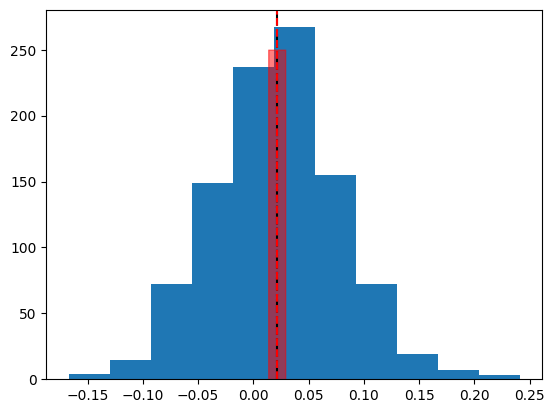

In [19]:
x = gp2[:, :, 0].mean()
s = gp2[:, :, 0].std() / np.sqrt(gp2.shape[0])

plt.hist(gp2[..., 0].mean(axis=1), bins=11)
plt.axvline(gp1[:, 0].mean(), c='k', ls='-.')
plt.axvline(gp2[:, :, 0].mean(), c='r', ls='--')
plt.fill_between(np.linspace(x - s*3 , x + s*3, 1000), 0, 250, alpha=0.5, color='r')

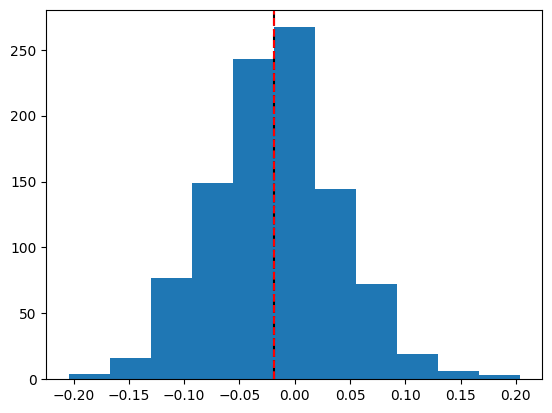

In [20]:
plt.hist(gm2[..., 0].mean(axis=1), bins=11)
plt.axvline(gm1[:, 0].mean(), c='k', ls='-.')
plt.axvline(gm2[:, :, 0].mean(), c='r', ls='--')

In [21]:
# multiplicative bias 
m1 = (gp1[:, 0].mean() - gm1[:, 0].mean()) / 0.02 / 2 - 1 
m1

Array(-0.00033211, dtype=float64)

In [22]:
m2 = (gp2[:, :, 0].mean(axis=1) - gm2[:,:, 0].mean(axis=1)) / 0.02 / 2 - 1 
m2.shape

(1000,)

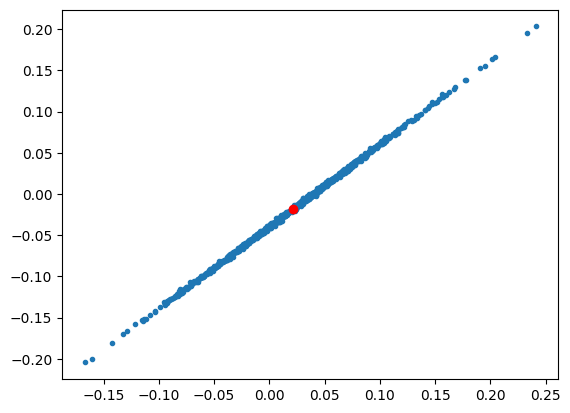

In [23]:
plt.plot(gp2[:, :, 0].mean(axis=1), gm2[:,:, 0].mean(axis=1), 'o', ms=3)
plt.plot(gp1[:, 0].mean(), gm1[:, 0].mean(), 'o', c='r')

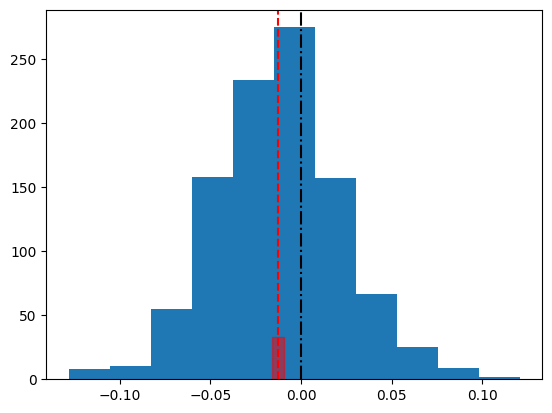

In [24]:
plt.hist(m2, bins=11)
plt.axvline(m1,  c='k', ls='-.')
plt.axvline(m2.mean(), c='r', ls='--')


x = m2.mean() 
s = m2.std() / np.sqrt(m2.shape[0])
plt.fill_between(np.linspace(x - s * 3, x + s * 3, 1000), 0, 33, color='r', alpha=0.5)

In [25]:
m2.std() / np.sqrt(1000)

Array(0.00109474, dtype=float64)

In [26]:
m1, m2.mean()

(Array(-0.00033211, dtype=float64), Array(-0.01270217, dtype=float64))

## Additive bias 

In [150]:
c1 = (gp1[:, 1].mean() + gm1[:, 1].mean()) / 2 
c2 = (gp2[...,1].mean(1) + gm2[...,1].mean(1)) / 2
c1.shape, c2.shape

((), (1000,))

(array([  3.,   3.,  10.,  30.,  43.,  49.,  69.,  98., 111., 116., 118.,
        109.,  90.,  60.,  44.,  24.,  12.,   7.,   2.,   1.,   1.]),
 array([-0.164569  , -0.14741378, -0.13025856, -0.11310334, -0.09594813,
        -0.07879291, -0.06163769, -0.04448247, -0.02732725, -0.01017203,
         0.00698319,  0.02413841,  0.04129363,  0.05844884,  0.07560406,
         0.09275928,  0.1099145 ,  0.12706972,  0.14422494,  0.16138016,
         0.17853538,  0.1956906 ]),
 <BarContainer object of 21 artists>)

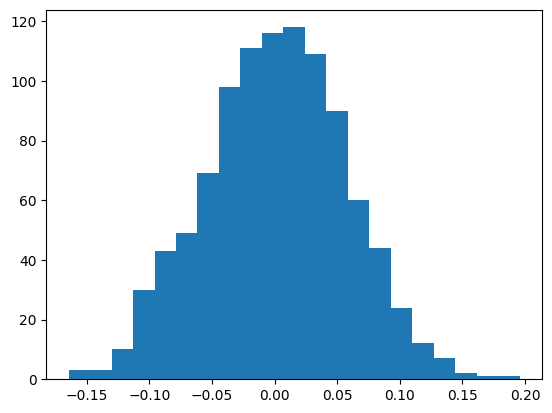

In [151]:
plt.hist(c2, bins=21)

In [152]:
c1, c2.mean()

(Array(0.00103605, dtype=float64), Array(0.00089804, dtype=float64))

In [153]:
c2.std() / np.sqrt(1000)

Array(0.00176576, dtype=float64)